In [6]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,Dropout,Convolution2D
from keras.layers import MaxPooling2D
from keras.models import Model
from keras.preprocessing import image
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import h5py
from keras.models import model_from_json
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from Preprocessing import img_dir

Importing files making sure its categorical

In [7]:

noise = pd.read_csv('noise_classified.csv',header=None)
labels_noise= pd.read_csv("attribute_list.csv",skiprows=1)
labels_noise['noise']=noise.loc[:,1]
labels= labels_noise[labels_noise['noise']==1]
attribute='hair_color'
itrain_test_data=labels.loc[:,['file_name',attribute]]
#train_test_data.loc[:,['file_name',attribute]]
#train_test_data[attribute]= train_test_data[attribute].apply(lambda x: 0 if x < 1  else 1)
train_test_data= itrain_test_data[itrain_test_data[attribute]>0]

In [8]:
s = pd.Series(list(train_test_data[attribute]))
s1=pd.get_dummies(s)
s1.shape
train_test_data.head()



,file_name,hair_color
0,1,1
1,2,4
2,3,5
6,7,2
7,8,3


Importing Images Normalizing them and splitting into training and test set

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train_test_data, test_size=0.2)

picture_shape=(64,64)

y_train= pd.Series(list(train[attribute]))
y_train= pd.get_dummies(y_train)
y_test=pd.Series(list(test[attribute]))
y_test= pd.get_dummies(y_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

i=0
x_train=np.zeros((len(train[attribute]),picture_shape[0],picture_shape[1],3))
for x in list(train['file_name']):
    temp= image.load_img(img_dir+str(x)+'.png',target_size=(picture_shape))
    x_train[i,:,:,:]=image.img_to_array(temp)
    i=i+1
i=0
x_test=np.zeros((len(test[attribute]),picture_shape[0],picture_shape[1],3))
for x in list(test['file_name']):
    temp= image.load_img(img_dir+str(x)+'.png',target_size=(picture_shape))
    x_test[i,:,:,:]=image.img_to_array(temp)
    i=i+1
x_train,x_test = x_train/255.0,x_test/255.0

## Creating Model

In [28]:
def customModel(input_shape):
    
    
    
   # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (5, 5), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    #X = Dropout(.3)(X)
    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool_0')(X)
    
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(50, (2, 2), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    X = Dropout(.3)(X)
    X = MaxPooling2D((3, 3), name='max_pool_1')(X)
    
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(256, activation='relu', name='fc0')(X)
    X = Dropout(.3)(X)
    X = Dense(128, activation='relu', name='fc1')(X)
    X = Dropout(.3)(X)
    X = Dense(5, activation='softmax', name='fc2')(X)
    

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='cutomModel')

    return model

## Creating custom Callbacks and training Model

In [29]:
agemodel=customModel(x_train.shape[1:])
agemodel.compile(optimizer='Adam',loss='categorical_crossentropy',metrics = ["accuracy"])
monitor= EarlyStopping(monitor='val_acc',min_delta=1e-3,patience=5,verbose=1,mode='auto')
checkpointer =ModelCheckpoint(filepath='hairclassification_best_weights.hdf5',verbose=1,save_best_only=True)
#agemodel.fit(x=x_train, y=y_train.T,epochs=15,batch_size=32) # to see how long it will take
history = agemodel.fit(x=x_train, y=y_train, validation_split=0.2, epochs=40, batch_size=16,callbacks=[monitor,checkpointer], verbose=1)

Train on 2348 samples, validate on 588 samples
Epoch 1/40
2348/2348 [==============================] - 114s 48ms/step - loss: 2.2679 - acc: 0.5396 - val_loss: 1.4685 - val_acc: 0.3963

Epoch 00001: val_loss improved from inf to 1.46849, saving model to hairclassification_best_weights.hdf5
Epoch 2/40
2348/2348 [==============================] - 113s 48ms/step - loss: 0.6605 - acc: 0.7479 - val_loss: 0.6917 - val_acc: 0.7585

Epoch 00002: val_loss improved from 1.46849 to 0.69175, saving model to hairclassification_best_weights.hdf5
Epoch 3/40
2348/2348 [==============================] - 127s 54ms/step - loss: 0.5374 - acc: 0.7947 - val_loss: 0.5640 - val_acc: 0.7891

Epoch 00003: val_loss improved from 0.69175 to 0.56404, saving model to hairclassification_best_weights.hdf5
Epoch 4/40
2348/2348 [==============================] - 122s 52ms/step - loss: 0.4092 - acc: 0.8450 - val_loss: 0.4938 - val_acc: 0.7891

Epoch 00004: val_loss improved from 0.56404 to 0.49377, saving model to haircl

Loading Best weights and Saving model

In [143]:
agemodel.load_weights('hairclassification_best_weights.hdf5')
agemodel.save('hairclassification.h5')

Evaluating

In [144]:
from keras.models import load_model
cagemodel=load_model('hairclassification.h5')
preds =cagemodel.evaluate(x =x_test, y =y_test)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

735/735 [==============================] - 11s 15ms/step

Loss = 0.2685149473296542
Test Accuracy = 0.9047619047619048



## Ploting Graphs

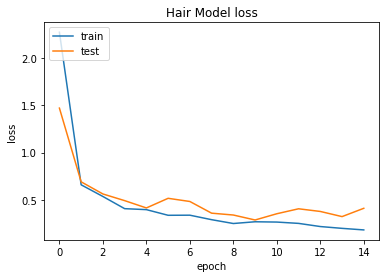

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Hair Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

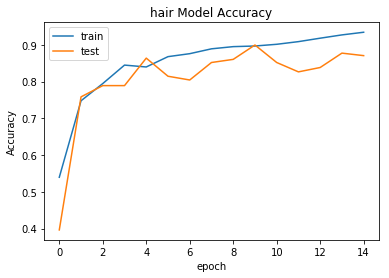

In [33]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('hair Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Exporting CSV

In [101]:
import pandas as pd
yhat=agemodel.predict(x_test)
df =pd.DataFrame(test['file_name'],index=None)
yhat=np.round(yhat,0)
df1 =pd.DataFrame(yhat)
for e in range (5):
    
    df1.iloc[:,e]=df1.iloc[:,e]*(e+1)
df['pred']=list(df1.max(axis=1))
pred=np.array(df)
np.savetxt('Task5.csv', pred, delimiter=',',header=str(preds[1]))


## Importing Test Dataset

In [145]:
i=0
NewTest=np.zeros((100,picture_shape[0],picture_shape[1],3))
for x in range(1,101):
    temp= image.load_img('testing_dataset/'+str(x)+'.png',target_size=(picture_shape))
    NewTest[i,:,:,:]=image.img_to_array(temp)
    i=i+1
NewTest=NewTest/255

Predicting and exporting to csv

In [146]:

yhat=cagemodel.predict(NewTest)
yhat=np.round(yhat,0)
df1 =pd.DataFrame(yhat)
for e in range (5):
    
    df1.iloc[:,e]=df1.iloc[:,e]*(e+1)



In [147]:
df = pd.DataFrame(list(range(1,101)))
df['pred']=list(df1.max(axis=1))
pred=np.array(df)
np.savetxt('Testing_dataset_Task5.csv', pred, delimiter=',',header=str(preds[1]))

